# Assignment 2

**Submission deadline: last lab session before or on Thursday, 26.03.2020**

**Points: 6 + 1 bonus points**

## Submission instructions
The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment2_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restar and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook with your instructor using his `cs.uni.wroc.pl` email

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D` matrix.

Text(0, 0.5, 'X[1]')

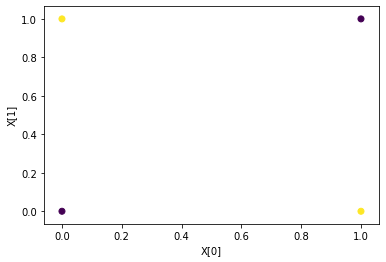

In [0]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numbers - answers
Y = np.array(
    [[0],
     [1],
     [1],
     [0],
    ], dtype=np.float32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0], )
plt.xlabel('X[0]')
plt.ylabel('X[1]')

# Problem 1 [2p]

Fill in the details of a forward pass, then manually set the weights and biases in the network to solve the 2D XOR task defined above.

In [0]:
def sigmoid(x):
    return np.double(1.0) / (np.double(1.0) + np.exp(-x))

class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(0, 0.5, self.W1.shape)
        self.b1 = np.random.normal(0, 0.5, self.b1.shape)
        self.W2 = np.random.normal(0, 0.5, self.W2.shape)
        self.b2 = np.random.normal(0, 0.5, self.b2.shape)

    def forward(self, X, Y=None, do_backward=False):
        # Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = np.matmul(X, self.W1.transpose()) + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        # Inputs to neuron in the second layer
        A2 = np.matmul(O1, self.W2.transpose()) + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        if Y is not None:
            loss = - Y * np.log(O2) - (np.double(1.0) - Y) * np.log(np.double(1.0) - O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss
            batch_size = X.shape[0] 
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.sum(0) / batch_size
            self.W2_grad = np.multiply(O1, 
                                       np.repeat(A2_grad, O1.shape[1], axis=1)
                                       ).sum(0)[np.newaxis, :] / batch_size
            O1_grad = np.dot(A2_grad, self.W2)
            A1_grad = np.multiply(O1_grad, np.multiply(O1, (1 - O1)))
            self.b1_grad = A1_grad.sum(0) / batch_size
            self.W1_grad = np.multiply(np.repeat(X[:, np.newaxis, :],
                                                 A1_grad.shape[1],
                                                 axis = 1),
                                       np.repeat(A1_grad[:, :, np.newaxis],
                                                 X.shape[1], 
                                                 axis = 2)).sum(0) / batch_size

        return O2, loss

In [0]:
# Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[5.0, 5.0], [5.0, 5.0]])
net.b1 = np.array([-2.5, -7.5])
net.W2 = np.array([[5.0, -5.0]])
net.b2 = np.array([-2.5])

# Hint: since we use the logistic sigmoid activation, the weights may need to 
# be fairly large 


net.forward(X, Y, do_backward=True)

(array([[0.10683622],
        [0.85086711],
        [0.85086711],
        [0.10683622]]), 0.13724231150961305)

# Problem 2 [2p]

1. Fill in the backward pass.
2. Implement random initialization of network parameters.
3. Using `float64` verify correctness of your backward pass.

In [0]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""
    
    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + '_grad')
    assert (param.shape == orig_grad.shape)

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (
            loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [0]:
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ['W1', 'b1', 'W2', 'b2']:
    check_grad(net, param_name, X, Y)

# Problem 3 [2p]

Fill in the details of batch gradient descent below, then train a network to solve 2D XOR problem.

Then test the reliability of solving the 3D XOR task.

In [0]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        grad = getattr(net, param_name + '_grad')
        param[:] = param - grad

0 0.7017737378746061
5000 0.0009439128818267353
10000 0.0004259388180536731
15000 0.00027158447687281886
20000 0.0001982946985474811
25000 0.00015570827053192513
30000 0.00012795229973020845
35000 0.00010846422201950202
40000 9.404676977389029e-05
45000 8.29588793074614e-05
50000 7.417262590415466e-05
55000 6.704258505395904e-05
60000 6.114335044638583e-05
65000 5.6183301929908986e-05
70000 5.195593671920855e-05
75000 4.831098105027684e-05
80000 4.513650565027148e-05
85000 4.234745096686793e-05
90000 3.987803538204718e-05
95000 3.767659659830131e-05


In [0]:
net.forward(X, Y, do_backward=True)

(array([[2.65360389e-05],
        [9.99974527e-01],
        [9.99954949e-01],
        [4.57449315e-05]]), 3.570200331866367e-05)

Generate below data for a 3D XOR task. Try a few values of hidden layer size. Plot the reliability of training, i.e. how many trainings succeed for a given hiden layer size.

What is easier to train: a smaller, or large network?

In [0]:
X3 = np.array(
    [[0, 0, 0],
     [0, 0, 1],
     [0, 1, 0],
     [0, 1, 1],
     [1, 0, 0],
     [1, 0, 1],
     [1, 1, 0],
     [1, 1, 1],
    ], dtype=np.float32)
Y3 = np.array(
    [[0],
     [1],
     [1],
     [0],
     [1],
     [0],
     [0],
     [0],
    ], dtype=np.float32)

alpha = 0.1
for hidden_dim in [2, 3, 5, 10, 20]:
    # Run a few trainings and record the fraction of successful ones

    succ_trainings = 0.0
    for train in range(50):
        net = SmallNet(3, hidden_dim, dtype=np.float64)
        for i in range(10000):
            _, loss = net.forward(X3, Y3, do_backward=True)
            for param_name in ['W1', 'b1', 'W2', 'b2']:
                param = getattr(net, param_name)
                grad  = getattr(net, param_name + '_grad')
                param[:] = param - grad
            if i == 9999 and loss < 0.001:
                succ_trainings += 0.02
    print("Hidden layer size:", hidden_dim)
    print("Succesfull trainings:", np.around(succ_trainings, decimals=2), "\n")


Hidden layer size: 2
Succesfull trainings: 0.0 

Hidden layer size: 3
Succesfull trainings: 0.64 

Hidden layer size: 5
Succesfull trainings: 1.0 

Hidden layer size: 10
Succesfull trainings: 1.0 

Hidden layer size: 20
Succesfull trainings: 1.0 



# Problem 4 [1bp]

Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Verify ho

In [0]:
def ReLU(x):
    return np.maximum(x, 0, x)

class ReLUNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        self.W1 = np.random.normal(0, 0.5, self.W1.shape)
        self.b1 = np.random.normal(0, 0.5, self.b1.shape)
        self.W2 = np.random.normal(0, 0.5, self.W2.shape)
        self.b2 = np.random.normal(0, 0.5, self.b2.shape)

    def forward(self, X, Y=None, do_backward=False):
        A1 = np.matmul(X, self.W1.transpose()) + self.b1
        O1 = ReLU(A1)
        A2 = np.matmul(O1, self.W2.transpose()) + self.b2
        O2 = sigmoid(A2)

        if Y is not None:
            loss = - Y * np.log(O2) - (np.double(1.0) - Y) * np.log(np.double(1.0) - O2)
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            batch_size = X.shape[0] 
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.sum(0) / batch_size
            self.W2_grad = np.multiply(O1, 
                                       np.repeat(A2_grad, O1.shape[1], axis=1)
                                       ).sum(0)[np.newaxis, :] / batch_size
            O1_grad = np.dot(A2_grad, self.W2)
            A1_grad = np.multiply(O1_grad, np.multiply(O1, (1 - O1)))
            self.b1_grad = A1_grad.sum(0) / batch_size
            self.W1_grad = np.multiply(np.repeat(X[:, np.newaxis, :],
                                                 A1_grad.shape[1],
                                                 axis = 1),
                                       np.repeat(A1_grad[:, :, np.newaxis],
                                                 X.shape[1], 
                                                 axis = 2)).sum(0) / batch_size

        return O2, loss

In [0]:
net = ReLUNet(3, 10, dtype=np.float64)

alpha = 1e-1

for i in range(500):          # weights of matrixes get really big really fast, NaNs start to appear
    _, loss = net.forward(X3, Y3, do_backward=True)
    if (i % 50) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        grad = getattr(net, param_name + '_grad')
        param[:] = param - grad

0 0.7784596548632212
50 0.4173050986037896
100 0.269363878528261
150 0.22060437111490086
200 0.20256041447587372
250 0.1938722206667413
300 0.18888207426078868
350 0.18573426476143748
400 0.18359660558161184
450 0.18206156209087793
